In [ ]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models

In [ ]:
!tar -zxvf ../input/cifar10-python/cifar-10-python.tar.gz


tar (child): ../input/cifar10-python/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='.', train=True,download=True , transform=train_transform)
trainset,valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet34(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().cuda()
[x for x,y in model.named_children()]

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


['base', 'drop', 'final']

In [ ]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(5):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(),labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')  

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss 1: 0.42842723822026024,Train Acc:85.58571428571429%
Val accuracy:91.6125%
Train loss 2: 0.1646205101807912,Train Acc:94.60714285714286%
Val accuracy:94.425%
Train loss 3: 0.13129450657538005,Train Acc:95.57619047619048%
Val accuracy:94.725%
Train loss 4: 0.12544456390823636,Train Acc:95.88333333333334%
Val accuracy:94.45%
Train loss 5: 0.12896018520707175,Train Acc:95.75%
Val accuracy:94.475%
Finished Training
CPU times: user 20min 3s, sys: 5min 45s, total: 25min 49s
Wall time: 25min 50s


In [ ]:
%%time
correct = 0
model.load_state_dict(best_val_model)
model.train(False)
with torch.no_grad():
    for inputs,labels in testloader:
        out = model(inputs.cuda()).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        
        correct += acc
print(f"Test accuracy: {correct*100/len(testset)}%")

Test accuracy: 95.62%
CPU times: user 28.5 s, sys: 762 ms, total: 29.3 s
Wall time: 29.3 s


Text(0, 0.5, 'val_accuracy')

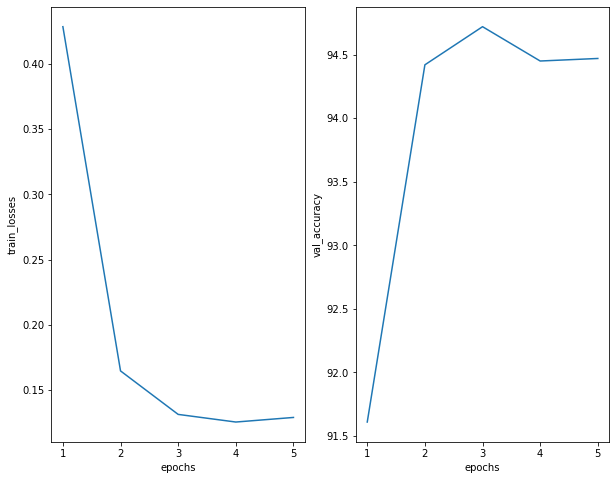

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
train_losses = [0.42842723822026024,0.1646205101807912,0.13129450657538005,0.12544456390823636,0.12896018520707175]
val_acc = [91.61,94.42,94.72,94.45,94.47]
epochs = [1,2,3,4,5]
plt.subplot(1,2,1)
plt.plot(epochs,train_losses)
plt.xlabel('epochs')
plt.ylabel('train_losses')
plt.subplot(1,2,2)
plt.plot(epochs,val_acc)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')